# Cell Analysis Utilities for CSV Data

This module provides functions for loading, analyzing, and visualizing 
cell measurement data from CSV files generated by the fluorescence 
microscopy processing pipeline.

In [1]:
# Necessary imports for the module
import os
import glob
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Union, Optional, Tuple


import AutoImgUtils as autils

In [2]:
%load_ext autoreload
%autoreload 2

## Function Definitions for Analysis

### Data I/O Functions

In [3]:
def load_csv_data(file_path: Union[str, Path]) -> pd.DataFrame:
    """
    Load cell measurement data from a CSV file.

    Parameters:
    - file_path: Path to the CSV file.

    Returns:
    - DataFrame containing the cell measurement data.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    df = pd.read_csv(file_path)
    
    # Ensure that the 'cell_id' column is present
    if 'cell_id' not in df.columns:
        raise ValueError("CSV file must contain a 'cell_id' column.")
    
    return df

In [4]:
def remove_outliers(df: pd.DataFrame, column: str, method: str = 'iqr', 
                   factor: float = 1.5) -> pd.DataFrame:
    """
    Remove outliers from a DataFrame based on a specific column.
    
    Parameters:
    - df: DataFrame containing the cell measurement data
    - column: Name of the column to use for outlier detection
    - method: Method for outlier detection ('iqr', 'zscore' or 'mad')
    - factor: Factor for outlier detection (1.5 for IQR, 3.0 for z-score typically and 3.5 for MAD)
    
    Returns:
    - DataFrame with outliers removed
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame. Available columns: {list(df.columns)}")
    
    df_clean = df.copy()
    
    if method == 'iqr':
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        mask = (df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)
        
    elif method == 'zscore':
        mean = df_clean[column].mean()
        std = df_clean[column].std()
        z_scores = np.abs((df_clean[column] - mean) / std)
        
        mask = z_scores <= factor
    elif method == 'mad':
        median = df_clean[column].median()
        mad = np.median(np.abs(df_clean[column] - median))
        lower_bound = median - factor * mad
        upper_bound = median + factor * mad
        
        mask = (df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)
        
    else:
        raise ValueError("Method must be either 'iqr' or 'zscore'")
    
    df_filtered = df_clean[mask].reset_index(drop=True)
    
    print(f"Removed {len(df) - len(df_filtered)} outliers ({((len(df) - len(df_filtered))/len(df)*100):.1f}%) based on column '{column}'")
    print(f"Original dataset: {len(df)} rows")
    print(f"Filtered dataset: {len(df_filtered)} rows")
    
    return df_filtered

In [5]:
def load_and_process_multiple_csvs(file_paths: List[Union[str, Path]], 
                                 outlier_column: str,
                                 method: str = 'mad',
                                 factor: float = 3.0,
                                 global_outlier_removal: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Load multiple CSV files, apply outlier removal, and return combined datasets.
    
    Parameters:
    - file_paths: List of paths to CSV files
    - outlier_column: Column to use for outlier detection
    - method: Outlier detection method ('iqr', 'zscore', 'mad')
    - factor: Factor for outlier detection
    - global_outlier_removal: Whether to apply additional outlier removal on combined data
    
    Returns:
    - original_combined: Combined original data with dataset labels
    - cleaned_combined: Combined cleaned data with dataset labels  
    - processing_stats: Dictionary with processing statistics
    """
    
    original_dfs = []
    cleaned_dfs = []
    processing_stats = {}
    global_cell_id = 0  # Global counter for unique cell IDs
    
    for i, file_path in enumerate(file_paths):
        # Load data
        df = load_csv_data(file_path)
        dataset_name = Path(file_path).stem
        
        # Store original cell_id for reference
        df['original_cell_id'] = df['cell_id']
        
        # Create unique cell_id across all datasets
        df['cell_id'] = range(global_cell_id, global_cell_id + len(df))
        global_cell_id += len(df)
        
        # Add dataset identifier
        df['dataset'] = dataset_name
        df['dataset_id'] = i
        
        # Store original
        original_dfs.append(df)
        
        # Remove outliers within dataset
        df_clean = remove_outliers(df, outlier_column, method, factor)
        
        # Ensure dataset info is preserved after outlier removal
        df_clean['dataset'] = dataset_name
        df_clean['dataset_id'] = i
        
        cleaned_dfs.append(df_clean)
        
        # Store stats
        processing_stats[dataset_name] = {
            'original_count': len(df),
            'cleaned_count': len(df_clean),
            'outliers_removed': len(df) - len(df_clean),
            'outlier_percentage': ((len(df) - len(df_clean))/len(df)*100)
        }
    
    # Combine datasets
    original_combined = pd.concat(original_dfs, ignore_index=True)
    cleaned_combined = pd.concat(cleaned_dfs, ignore_index=True)
    
    # Optional global outlier removal
    if global_outlier_removal:
        print("\nApplying global outlier removal...")
        cleaned_combined = remove_outliers(cleaned_combined, outlier_column, method, factor)
    
    return original_combined, cleaned_combined, processing_stats

def compare_datasets_statistics(df: pd.DataFrame, 
                              column: str, 
                              group_by: str = 'dataset') -> pd.DataFrame:
    """
    Calculate comparative statistics across datasets.
    
    Parameters:
    - df: Combined DataFrame with dataset labels
    - column: Column to analyze
    - group_by: Column to group by (default: 'dataset')
    
    Returns:
    - DataFrame with comparative statistics
    """
    stats = df.groupby(group_by)[column].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.25),  # Q1
        lambda x: x.quantile(0.75),  # Q3
    ]).round(3)
    
    stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3']
    stats['IQR'] = stats['Q3'] - stats['Q1']
    
    return stats

### Visualization (Statistics)

In [6]:
def plot_violin(df: pd.DataFrame, column: str, title: Optional[str] = None, 
                figsize: Tuple[int, int] = (8, 6)) -> None:
    """
    Create a violin plot for a specific column in the cell data DataFrame.
    
    Parameters:
    - df: DataFrame containing the cell measurement data
    - column: Name of the column to plot
    - title: Optional title for the plot
    - figsize: Figure size as (width, height)
    
    Returns:
    - None (displays the plot)
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame. Available columns: {list(df.columns)}")
    
    plt.figure(figsize=figsize)
    sns.violinplot(y=df[column])
    
    if title is None:
        title = f"Distribution of {column}"
    
    plt.title(title)
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

def plot_violin_comparison(datasets: List[pd.DataFrame], column: str, 
                            dataset_labels: Optional[List[str]] = None,
                            hue = None,
                            title: Optional[str] = None, 
                            figsize: Optional[Tuple[int, int]] = None) -> None:
    """
    Create violin plots comparing the same column across multiple datasets.
    
    Parameters:
    - datasets: List of DataFrames containing the cell measurement data
    - column: Name of the column to plot
    - dataset_labels: Optional list of labels for each dataset
    - title: Optional title for the plot
    - figsize: Optional figure size as (width, height). If None, adapts to number of datasets
    
    Returns:
    - None (displays the plot)
    """
    if not datasets:
        raise ValueError("At least one dataset must be provided")
    
    # Check if column exists in all datasets
    for i, df in enumerate(datasets):
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in dataset {i}. Available columns: {list(df.columns)}")
    
    # Set default labels if not provided
    if dataset_labels is None:
        dataset_labels = [f"Dataset {i+1}" for i in range(len(datasets))]
    elif len(dataset_labels) != len(datasets):
        raise ValueError("Number of dataset labels must match number of datasets")
    # Prepare data for seaborn
    combined_data = []
    for i, (df, label) in enumerate(zip(datasets, dataset_labels)):
        temp_df = pd.DataFrame({
            column: df[column],
            'Dataset': label
        })
        combined_data.append(temp_df)
    
    plot_data = pd.concat(combined_data, ignore_index=True)
    
    # Adaptive figure size
    if figsize is None:
        width = max(8, len(datasets) * 2)
        figsize = (width, 6)
    
    plt.figure(figsize=figsize)
    sns.violinplot(data=plot_data, x='Dataset', y=column , color= 'seagreen', log_scale=False)
    
    if title is None:
        title = f"Comparison of {column} across datasets"
    
    plt.title(title)
    plt.ylabel(column)
    plt.xticks(rotation=45 if len(dataset_labels) > 3 else 0)
    plt.tight_layout()
    plt.show()

## Cell-Analysis (Dark Experiments)

In [12]:
cell_data_path = autils.select_file()
print(f"Selected cell data file: {os.path.basename(cell_data_path)}")

Selected cell data file: DARK01_1_4_2_NB_5CO_Cal_DARK_4d-Scene-2-ScanRegion1-OME.ome_cells.csv


In [8]:
cell_data_no_dox_dark_path = autils.select_files()
cell_data_no_dox_light_path = autils.select_files()
cell_data_48_dox_dark_path = autils.select_files()
cell_data_48_dox_light_path = autils.select_files()
cell_data_cont_dox_dark_path = autils.select_files()
cell_data_cont_dox_light_path = autils.select_files()

In [20]:
cell_data_no_dox_dark =load_and_process_multiple_csvs(cell_data_no_dox_dark_path, outlier_column='channel_2_ctcf')
cell_data_no_dox_light = load_and_process_multiple_csvs(cell_data_no_dox_light_path, outlier_column='channel_2_ctcf')
cell_data_48_dox_dark = load_and_process_multiple_csvs(cell_data_48_dox_dark_path, outlier_column='channel_2_ctcf')
cell_data_48_dox_light = load_and_process_multiple_csvs(cell_data_48_dox_light_path, outlier_column='channel_2_ctcf')
cell_data_cont_dox_dark = load_and_process_multiple_csvs(cell_data_cont_dox_dark_path, outlier_column='channel_2_ctcf')
cell_data_cont_dox_light = load_and_process_multiple_csvs(cell_data_cont_dox_light_path, outlier_column='channel_2_ctcf')

Removed 67 outliers (1.1%) based on column 'channel_2_ctcf'
Original dataset: 6115 rows
Filtered dataset: 6048 rows
Removed 180 outliers (4.3%) based on column 'channel_2_ctcf'
Original dataset: 4165 rows
Filtered dataset: 3985 rows
Removed 167 outliers (3.0%) based on column 'channel_2_ctcf'
Original dataset: 5513 rows
Filtered dataset: 5346 rows
Removed 137 outliers (2.4%) based on column 'channel_2_ctcf'
Original dataset: 5682 rows
Filtered dataset: 5545 rows
Removed 141 outliers (2.5%) based on column 'channel_2_ctcf'
Original dataset: 5670 rows
Filtered dataset: 5529 rows
Removed 253 outliers (4.3%) based on column 'channel_2_ctcf'
Original dataset: 5883 rows
Filtered dataset: 5630 rows
Removed 141 outliers (2.7%) based on column 'channel_2_ctcf'
Original dataset: 5163 rows
Filtered dataset: 5022 rows
Removed 136 outliers (2.9%) based on column 'channel_2_ctcf'
Original dataset: 4658 rows
Filtered dataset: 4522 rows
Removed 84 outliers (1.8%) based on column 'channel_2_ctcf'
Origi

In [21]:
cell_data_list_dox_cal= [
    cell_data_no_dox_dark[1],
    cell_data_no_dox_light[1],
    cell_data_48_dox_dark[1],
    cell_data_48_dox_light[1],
    cell_data_cont_dox_dark[1],
    cell_data_cont_dox_light[1]
]

for i, dataset in enumerate(cell_data_list_dox_cal):
    dataset['Type'] = 'Cal'

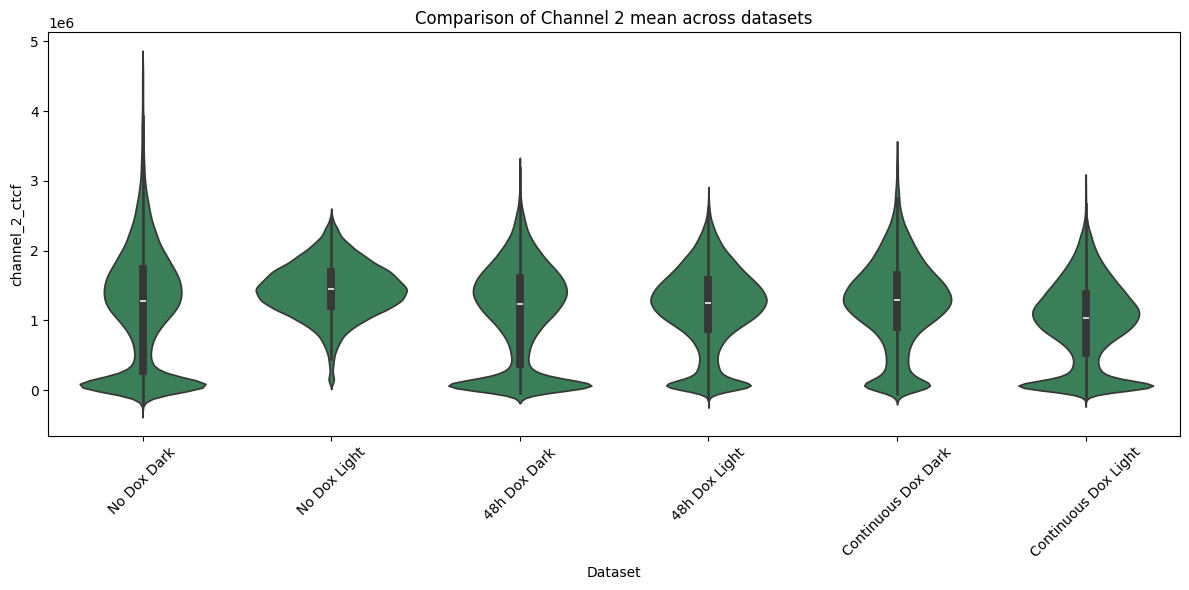

In [23]:
plot_violin_comparison(
    cell_data_list_dox_cal,
    column='channel_2_ctcf',
    dataset_labels=[
        'No Dox Dark', 
        'No Dox Light', 
        '48h Dox Dark', 
        '48h Dox Light', 
        'Continuous Dox Dark', 
        'Continuous Dox Light'
    ],
    title='Comparison of Channel 2 mean across datasets',
    # figsize=(12, 6)
)

In [45]:
cell_data_dark_1d = load_and_process_multiple_csvs(cell_data_dark_1d_paths, 
                                                  outlier_column='channel_2_ctcf')
cell_data_dark_2d = load_and_process_multiple_csvs(cell_data_dark_2d_paths,
                                                  outlier_column='channel_2_ctcf')
# cell_data_dark_3d = load_and_process_multiple_csvs(cell_data_dark_3d_paths,
#                                                   outlier_column='channel_2_ctcf')
cell_data_dark_4d = load_and_process_multiple_csvs(cell_data_dark_4d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_5d = load_and_process_multiple_csvs(cell_data_dark_5d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_6d = load_and_process_multiple_csvs(cell_data_dark_6d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_7d = load_and_process_multiple_csvs(cell_data_dark_7d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_8d = load_and_process_multiple_csvs(cell_data_dark_8d_paths,
                                                    outlier_column='channel_2_ctcf')

Removed 156 outliers (9.1%) based on column 'channel_2_ctcf'
Original dataset: 1719 rows
Filtered dataset: 1563 rows
Removed 252 outliers (14.1%) based on column 'channel_2_ctcf'
Original dataset: 1787 rows
Filtered dataset: 1535 rows
Removed 149 outliers (10.8%) based on column 'channel_2_ctcf'
Original dataset: 1385 rows
Filtered dataset: 1236 rows
Removed 109 outliers (5.1%) based on column 'channel_2_ctcf'
Original dataset: 2146 rows
Filtered dataset: 2037 rows
Removed 52 outliers (7.2%) based on column 'channel_2_ctcf'
Original dataset: 722 rows
Filtered dataset: 670 rows
Removed 206 outliers (14.0%) based on column 'channel_2_ctcf'
Original dataset: 1467 rows
Filtered dataset: 1261 rows
Removed 68 outliers (12.8%) based on column 'channel_2_ctcf'
Original dataset: 533 rows
Filtered dataset: 465 rows
Removed 40 outliers (2.9%) based on column 'channel_2_ctcf'
Original dataset: 1358 rows
Filtered dataset: 1318 rows
Removed 151 outliers (8.0%) based on column 'channel_2_ctcf'
Origin

In [37]:
cell_data_dark_1d[1].head()

,image,cell_id,area,channel_1_ctcf,channel_2_ctcf,channel_3_ctcf,channel_4_ctcf,channel_1_mean,channel_2_mean,channel_3_mean,channel_4_mean,centroid_x,centroid_y,original_cell_id,dataset,dataset_id
0,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,0,788,2.403011e+06,353722.566735,313277.330874,9.846658e+06,4330.532715,808.751282,582.601501,13299.583008,375.220795,11.241117,3,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,0
1,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,1,716,3.331949e+06,324791.829673,314438.315870,1.665167e+07,5934.586426,813.484619,624.201111,24060.347656,2302.388184,13.706703,3,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,0
2,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,2,628,3.423571e+06,186556.928820,166575.964199,1.119437e+07,6732.571777,656.929932,450.289825,18629.248047,3909.200684,14.143312,3,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,0
3,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,3,792,3.828552e+06,552075.107683,507834.165041,1.800530e+07,6115.056641,1056.929321,826.246216,23537.787109,779.883850,16.823233,3,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,0
4,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,4,756,4.411868e+06,200828.239152,171242.657539,5.051094e+06,7116.830566,625.510559,411.552887,7485.165039,320.341248,24.542328,3,DARK01_1_2_1_NB_5CO_Cal_DARK_1d-Scene-1-ScanRe...,0


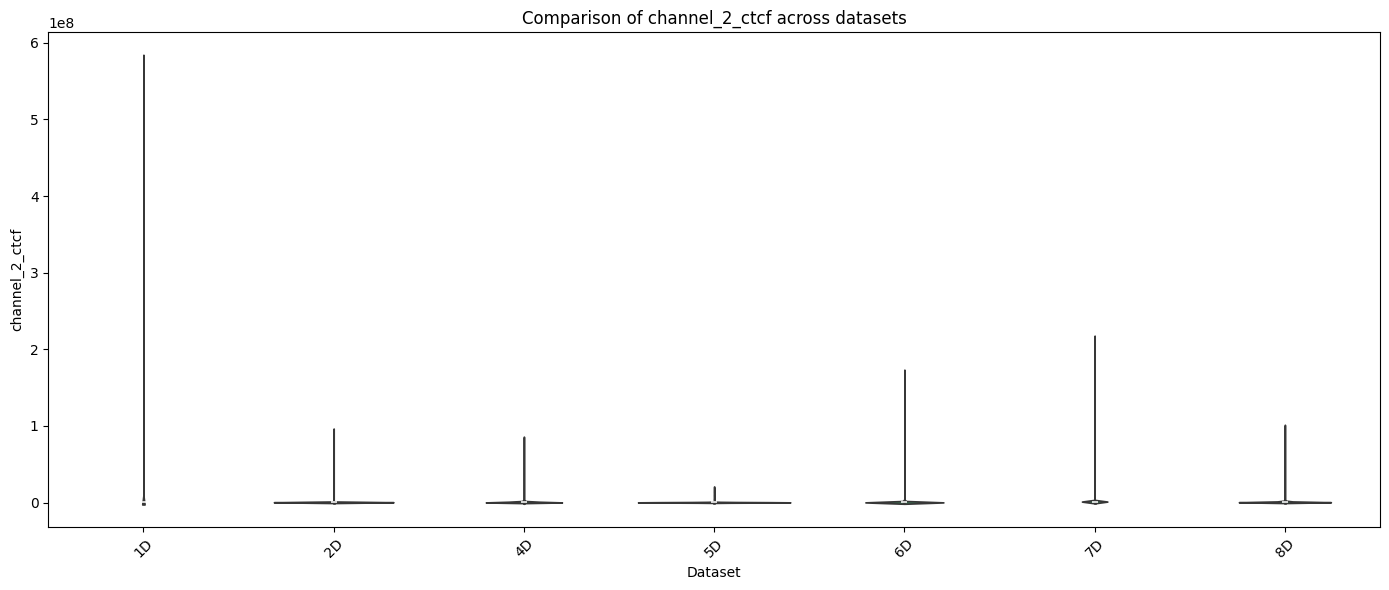

In [47]:
cell_data_list_original = [
    cell_data_dark_1d[0],cell_data_dark_2d[0],
    # cell_data_dark_3d[0],
    cell_data_dark_4d[0],
    cell_data_dark_5d[0],cell_data_dark_6d[0],
    cell_data_dark_7d[0],cell_data_dark_8d[0]
]

plot_violin_comparison(cell_data_list_original,
                       column='channel_2_ctcf',
                          dataset_labels=[
                            '1D', '2D', '4D', '5D', '6D', '7D', '8D'
                          ],
                          title='Comparison of channel_2_ctcf across datasets')

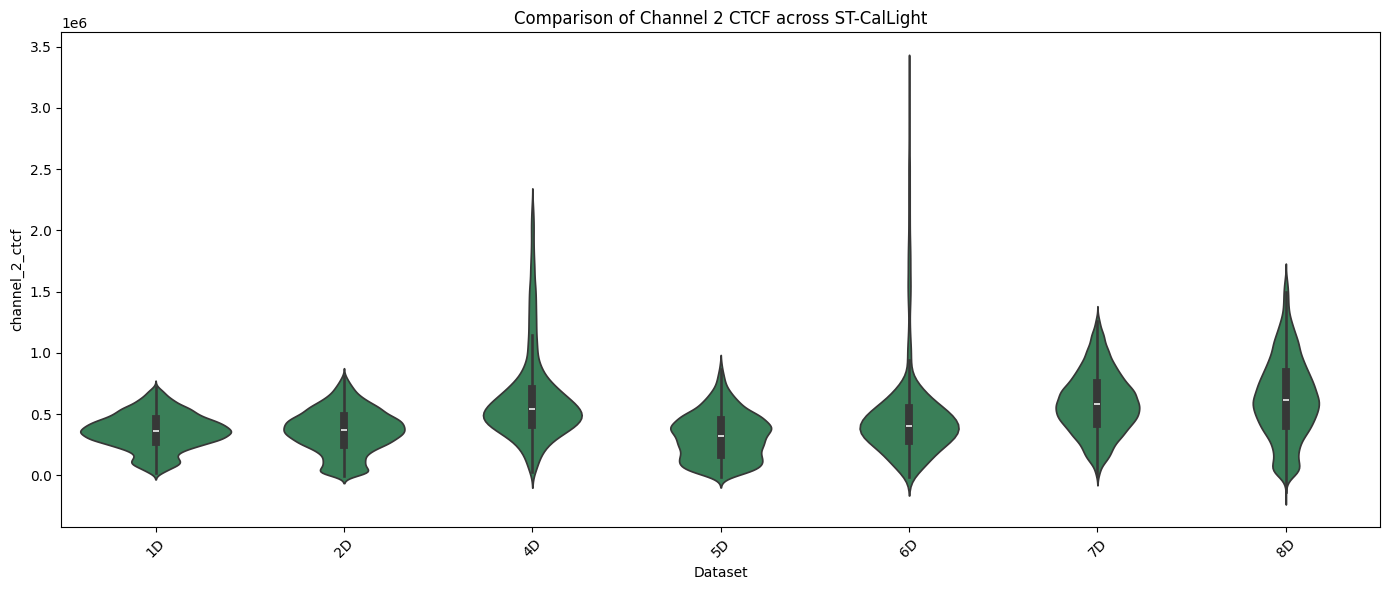

In [46]:
cell_data_list =  [cell_data_dark_1d[1], cell_data_dark_2d[1],
                    #cell_data_dark_3d[1], 
                    cell_data_dark_4d[1],
                    cell_data_dark_5d[1], cell_data_dark_6d[1],
                    cell_data_dark_7d[1], cell_data_dark_8d[1]]

plot_violin_comparison(cell_data_list,
                       column='channel_2_ctcf',
                       dataset_labels=['1D', '2D', '4D', '5D', '6D', '7D', '8D'],
                       title='Comparison of Channel 2 CTCF across ST-CalLight')

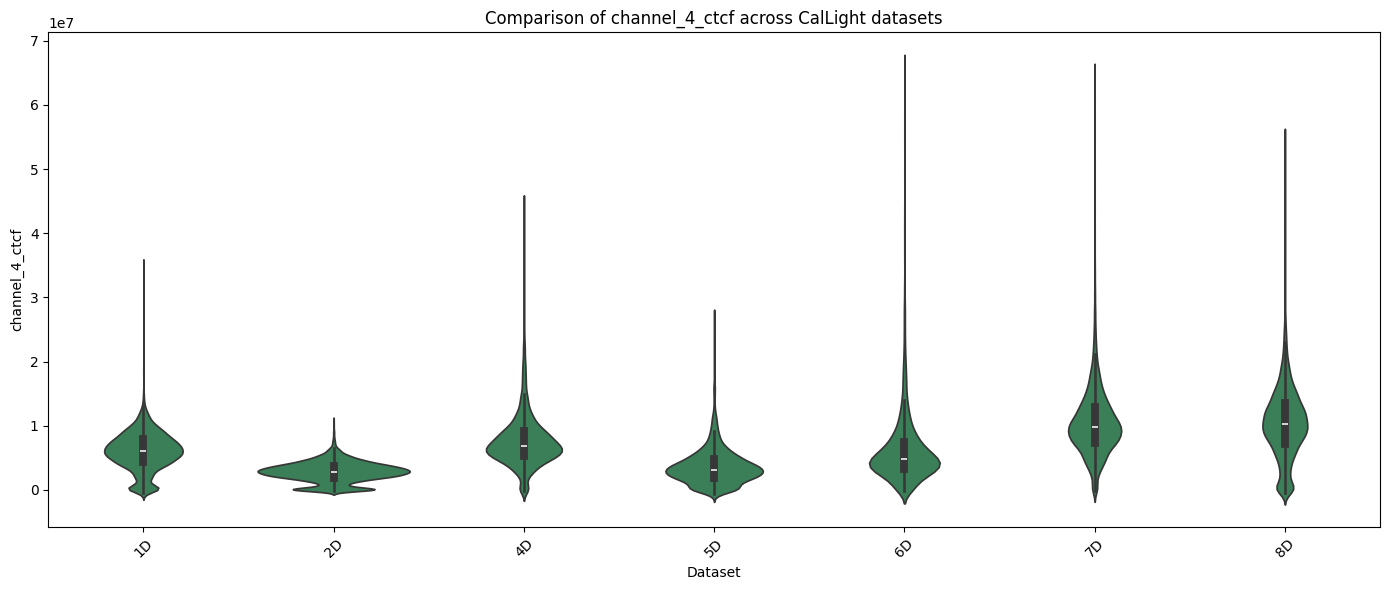

In [48]:
plot_violin_comparison(cell_data_list,
                       column='channel_4_ctcf',
                          dataset_labels=['1D', '2D', '4D', '5D', '6D', '7D', '8D'],
                          title='Comparison of channel_4_ctcf across CalLight datasets')

## Cell-Analysis (Dox-Experiment)

In [57]:
cal_dox_48_L_path = autils.select_files()
cal_dox_cont_L_path = autils.select_files()
cal_dox_no_L_path = autils.select_files()

cal_dox_48_D_paths = autils.select_files()
cal_dox_cont_D_paths = autils.select_files()
cal_dox_no_D_paths = autils.select_files()

In [58]:
cal_dox_48_L_df = load_and_process_multiple_csvs(cal_dox_48_L_path,
                                                outlier_column='channel_2_ctcf')
cal_dox_cont_L_df = load_and_process_multiple_csvs(cal_dox_cont_L_path,
                                                    outlier_column='channel_2_ctcf')
cal_dox_no_L_df = load_and_process_multiple_csvs(cal_dox_no_L_path,
                                                  outlier_column='channel_2_ctcf')

cal_dox_48_D_df = load_and_process_multiple_csvs(cal_dox_48_D_paths,
                                                outlier_column='channel_2_ctcf')
cal_dox_cont_D_df = load_and_process_multiple_csvs(cal_dox_cont_D_paths,
                                                    outlier_column='channel_2_ctcf')
cal_dox_no_D_df = load_and_process_multiple_csvs(cal_dox_no_D_paths,
                                                  outlier_column='channel_2_ctcf')

Removed 285 outliers (13.5%) based on column 'channel_2_ctcf'
Original dataset: 2106 rows
Filtered dataset: 1821 rows
Removed 271 outliers (11.5%) based on column 'channel_2_ctcf'
Original dataset: 2354 rows
Filtered dataset: 2083 rows
Removed 600 outliers (17.7%) based on column 'channel_2_ctcf'
Original dataset: 3399 rows
Filtered dataset: 2799 rows
Removed 398 outliers (15.7%) based on column 'channel_2_ctcf'
Original dataset: 2531 rows
Filtered dataset: 2133 rows
Removed 351 outliers (15.7%) based on column 'channel_2_ctcf'
Original dataset: 2230 rows
Filtered dataset: 1879 rows
Removed 679 outliers (15.3%) based on column 'channel_2_ctcf'
Original dataset: 4433 rows
Filtered dataset: 3754 rows
Removed 50 outliers (3.1%) based on column 'channel_2_ctcf'
Original dataset: 1608 rows
Filtered dataset: 1558 rows
Removed 78 outliers (2.2%) based on column 'channel_2_ctcf'
Original dataset: 3530 rows
Filtered dataset: 3452 rows
Removed 370 outliers (15.2%) based on column 'channel_2_ctcf

In [56]:
cell_data_list_dox = [
    cal_dox_48_L_df[1], cal_dox_cont_L_df[1], cal_dox_no_L_df[1],
    cal_dox_48_D_df[1], cal_dox_cont_D_df[1], cal_dox_no_D_df[1]
]

for i, dataset in enumerate(cell_data_list_dox):
    dataset['Type'] = 'Cal'


In [59]:
cell_data_list_dox_scfl = [
    cal_dox_48_L_df[1], cal_dox_cont_L_df[1], cal_dox_no_L_df[1],
    cal_dox_48_D_df[1], cal_dox_cont_D_df[1], cal_dox_no_D_df[1]
]

for i, dataset in enumerate(cell_data_list_dox_scfl):
    dataset['Type'] = 'scFL'

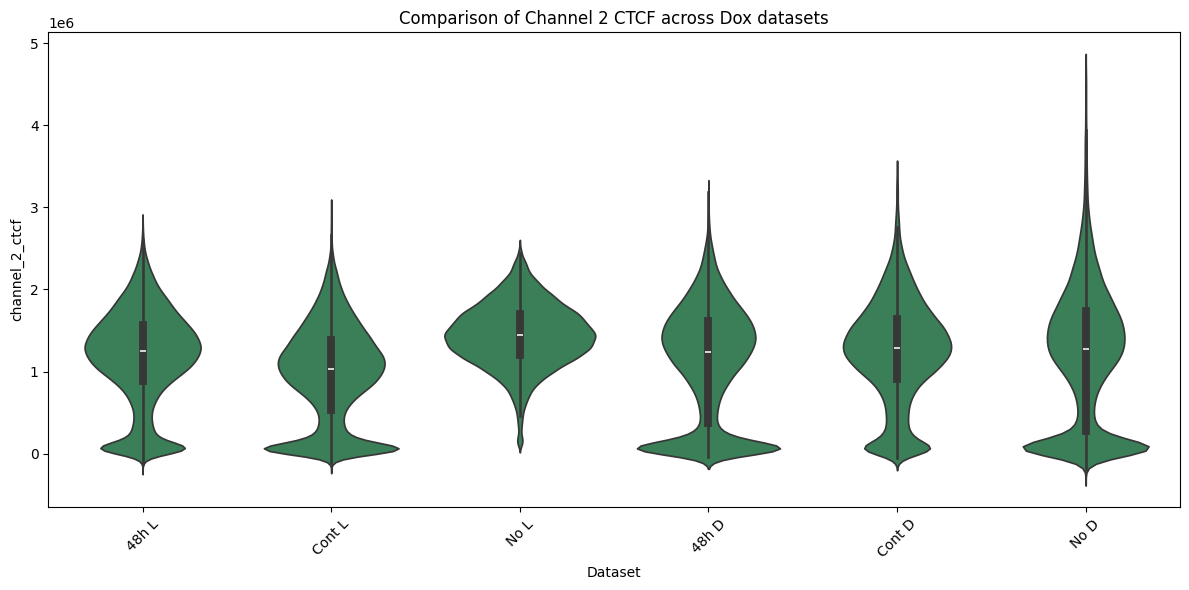

In [65]:

plot_violin_comparison(cell_data_list_dox,
                       column='channel_2_ctcf',
                       dataset_labels=['48h L', 'Cont L', 'No L', '48h D', 'Cont D', 'No D'],
                       title='Comparison of Channel 2 CTCF across Dox datasets')

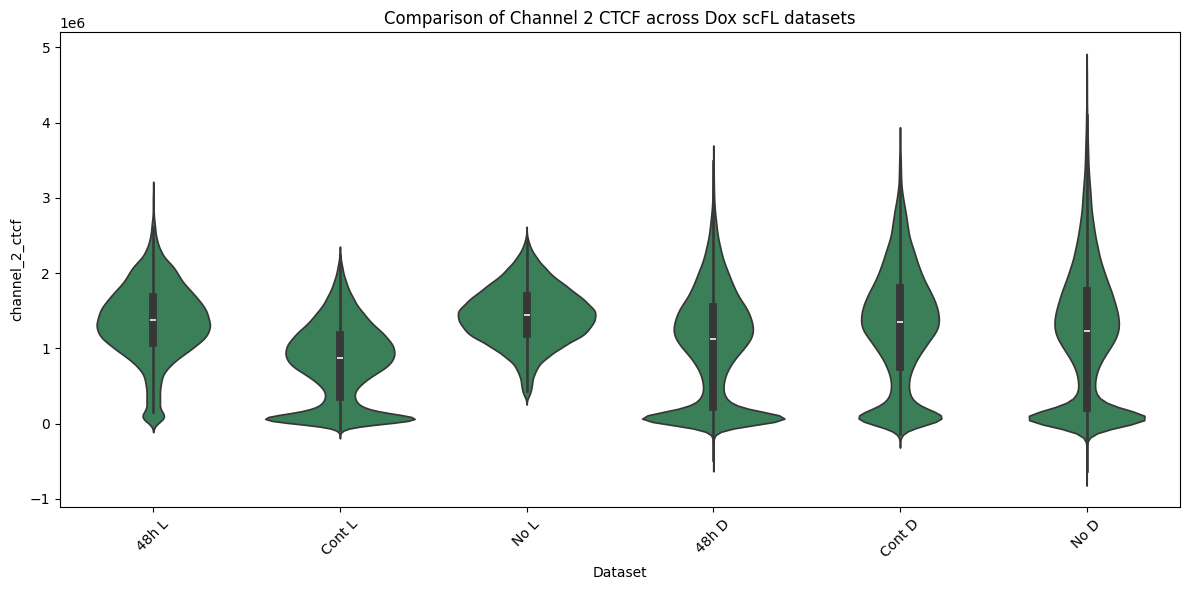

In [64]:
plot_violin_comparison(cell_data_list_dox_scfl,
                       column='channel_2_ctcf',
                       dataset_labels=['48h L', 'Cont L', 'No L', '48h D', 'Cont D', 'No D'],
                       title='Comparison of Channel 2 CTCF across Dox scFL datasets')